# Exploration_09

## 1. Movie_Review

### 1.1 Module

- 사용할 패키지를 설치합니다.  
출력이 길어 출력부분은 생략합니다.

In [ ]:
!pip install gensim

In [ ]:
!pip install konlpy

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [4]:
import re
import os
import pandas as pd
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from konlpy.tag import Okt, Mecab
import missingno as msno
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter
from sklearn import model_selection

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

from google.colab import drive

In [5]:
%matplotlib inline

### 1.2 Function

#### 1.2.1 load_data

- tokenize, stopword, word_to_index, indexlist를 수행합니다.

In [39]:
def load_data(train_data, test_data, num_words):
    X_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence)
        temp_x = [word for word in temp_x if not word in stopwords]   # 불용어 제거 
        X_train.append(temp_x)
        
    X_test = []
    for sentence in test_data['document']:
        temp_x_test = tokenizer.morphs(sentence)
        temp_x_test = [word for word in temp_x_test if not word in stopwords]   # 불용어 제거 
        X_test.append(temp_x_test)
        
    
    # word_to_index 만들기  
    words = np.concatenate(X_train).tolist()      # train data를 list로 만든다.
    counter = Counter(words)                      # 각 단어의 갯수와 단어를 키, 밸루로 하는 딕셔너리 생성 
    counter = counter.most_common(num_words-4) 
                                       # pad, bos, unk, unused 를 제외하고 가장 자주나오는 만개의 단어를 가져온다. (딕셔너리)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스트링 -> 인덱스 스트링 
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    

#### 1.2.2 review_predict

- review text를 넣으면 만들어진 model로 predict하여 score를 반환하는 함수입니다.

In [ ]:
def review_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = tokenizer_m.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = 83) # 패딩
  score = float(loaded_model1_3.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

### 1.3 Data

#### 1.3.1 Data Load

- 구글 드라이브를 마운트합니다.

In [8]:
drive.mount('/gdrive')

Mounted at /gdrive


- 사용할 데이터를 불러옵니다.

In [9]:
train_data = pd.read_table('/gdrive/My Drive/Colab Notebooks/data/movie/ratings_train.txt')
test_data = pd.read_table('/gdrive/My Drive/Colab Notebooks/data/movie/ratings_test.txt')

- 영화 리뷰와 리뷰에 따른 label이 잘 붙어있는 것을 확인할 수 있습니다.

In [ ]:
train_data.tail(3)

,id,document,label
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


In [ ]:
test_data.tail(3)

,id,document,label
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0
49999,6070594,마무리는 또 왜이래,0


- index를 보니 train 15만, test 5만개의 데이터가 있습니다.

#### 1.3.2 Data Preprocessing

- missingno를 통해 테이터의 null 값을 확인합니다.

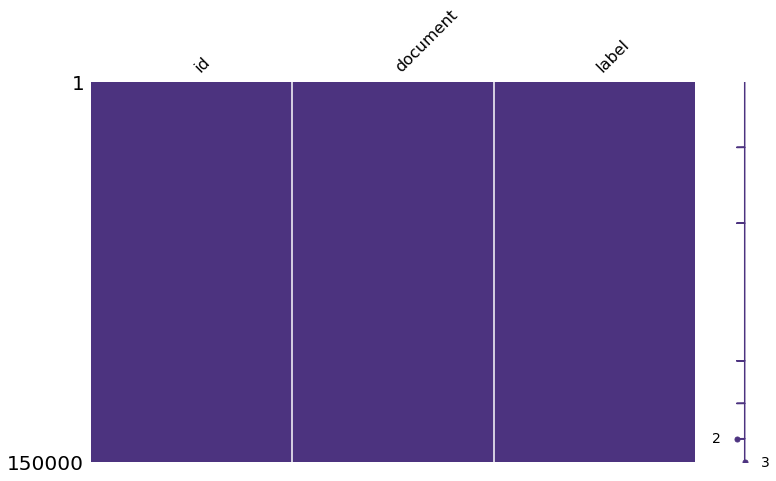

In [ ]:
msno.matrix(df=train_data.iloc[:, :], color=(0.3, 0.2, 0.5), figsize=(12,7))

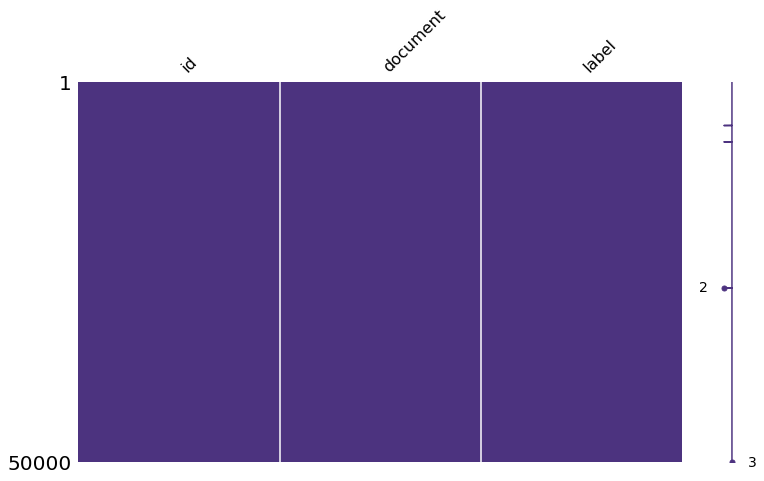

In [ ]:
msno.matrix(df=test_data.iloc[:, :], color=(0.3, 0.2, 0.5), figsize=(12,7))

- missingno martix의 우측 sparkline을 보면 데이터의 결측이 있는 것을 확인할 수 있습니다만, 잘 안보이니 isnull로 확인합니다.

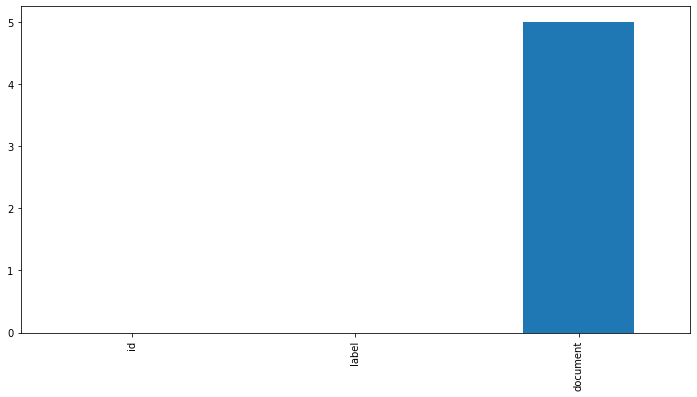

In [ ]:
missing = train_data.isnull().sum()
missing = missing[missing >= 0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize = (12,6))

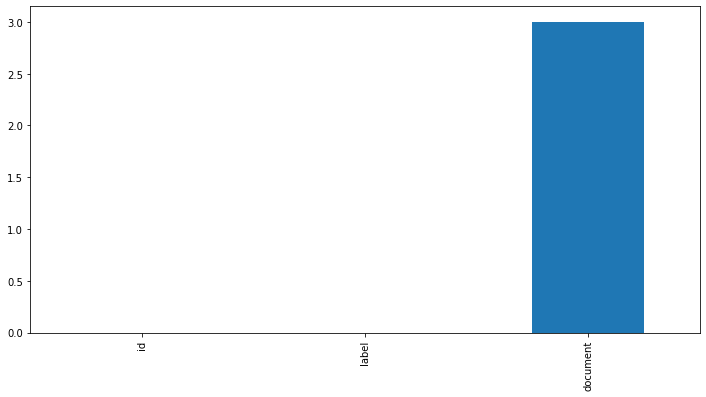

In [ ]:
missing = test_data.isnull().sum()
missing = missing[missing >= 0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize = (12,6))

- train의 document 컬럼에 5개, test의 document 컬럼에 3개의 null값이 존재합니다.

- nunique를 이용해 중복데이터도 확인합니다.  
이번에는 간단하게 텍스트로 봅니다.

In [ ]:
print('train | id : ', train_data['id'].nunique())
print('train | document : ', train_data['document'].nunique())
print('=================================')
print('test | id : ', test_data['id'].nunique())
print('test | document : ', test_data['document'].nunique())

train | id :  150000
train | document :  146182
test | id :  50000
test | document :  49157


- 찾았으니 처리해줍니다.

- drop_duplicates로 중복을 제거합니다.

In [10]:
train_data.drop_duplicates(subset=['document'], keep='first', inplace=True)
test_data.drop_duplicates(subset=['document'], keep='first', inplace=True)

- 아까 찾은 null값도 제거합니다.

In [11]:
train_data = train_data.dropna()
test_data = test_data.dropna()

- 한글 리뷰를 분석하므로 한글과 공백을 제외하고 나머지는 제거해줍니다.

In [12]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


- 공백이 발생할 수 있으므로 공백을 null값으로 바꿔줍니다.

In [13]:
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [14]:
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


- 다시 null값을 제거합니다.

In [15]:
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

- train에서 4,607개 / test에서 1,148개가 줄었습니다.

In [ ]:
print(len(train_data),len(test_data))

145393 48852


#### 1.3.3 Tokenize

- Mecab을 이용해 tokenize를 진행하고 쓸데없는 조사, 접속사 등의 불용어 제거를 위한 리스트를 만듭니다.

In [ ]:
tokenizer_m = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

- 위에서 작성한 함수로 처리합니다.
- 토큰화, 불용어 처리, 사전까지 만들어 X_train, y_train, X_test, y_test로 리턴합니다.

In [ ]:
X_train = []
for sentence in train_data['document']:
    temp_x_train = tokenizer_m.morphs(sentence)
    temp_x_train = [word for word in temp_x_train if not word in stopwords]   
    X_train.append(temp_x_train)

X_test = []
for sentence in test_data['document']:
    temp_x_test = tokenizer_m.morphs(sentence)
    temp_x_test = [word for word in temp_x_test if not word in stopwords]   
    X_test.append(temp_x_test)

In [ ]:
print(len(X_train))

145393


- 바로 단어장을 만듭니다.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

- tokenizer.word_index를 보면 단어장에 1부터 49946까지 존재하는 것을 확인할 수 있습니다(너무 길어 출력은 생략합니다)
- 단어장에서 빈도수에 따라 단어를 제거하지만, labeling이 끝난 문장의 단어들이라 제거할 필요가 없다고 판단하여 그냥 살려둡니다.

In [ ]:
total_cnt = len(tokenizer.word_index)
print(total_cnt)

49946


- vocab size는 총 단어에 pad를 포함하기위해 +1을 해줬습니다.

In [ ]:
vocab_size = total_cnt + 1

- vocab_size를 tokenizer에 넣고 텍스트 시퀀스를 정수 시퀀스로 변환합니다.

In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

- label 컬럼은 y_train과 y_test로 array 형태로 넣어줍니다.

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
print(len(X_train))
print(len(y_train))

145393
145393


- 토큰화 과정에서 빈 샘플을 제거합니다.

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
print(len(X_train))
print(len(y_train))

145380
145380


- 리뷰의 길이를 확인합니다(주로 5~15사이에 몰려있습니다)
- 리뷰의 길이에서 maxlen을 정해주는데 최대 길이를 그대로 가져가겠습니다.  
만약 길이로 문장을 제거하려했다면 토큰화전에 제거하는 것이 좋을 것 같습니다.

리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 13.801348190947861


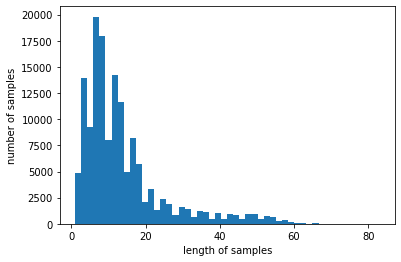

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- post-padding은 문장의 뒷부분에 pad가 들어가 마지막 단어로 pad가 입력으로 들어갈 수 있습니다.  
반대로, pre-padding같은 경우에는 문장 앞부분에 pad가 채워져 마지막 단어로 pad가 들어가는 일이 없습니다.  
LSTM같은 순차적인 특성의 시퀀스 모델링의 올바른 진행을 위해서는 pre-padding을 사용한다고 합니다.  
물론 저도 LSTM층을 사용해 모델을 구성했으므로 pre-padding을 진행합니다.

In [65]:
max_len = 83

In [ ]:
X_train = pad_sequences(X_train, padding='pre', maxlen=max_len)
X_test = pad_sequences(X_test, padding='pre', maxlen=max_len)
print(X_train.shape)
print(y_train.shape)

(145380, 83)
(145380,)


In [ ]:
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0  24  64 892  30 211  12  25 696]


- padding까지 잘 된 것을 확인할 수 있습니다.

### 1.2 Model

- model을 설계합니다.  
LSTM, dense layer를 사용하며 dropout으로 과적합을 방지합니다.  
- 모든 model은 ealrystopping과 modelcheckpoint를 활용합니다.  
- epochs는 30, batch_size는 256으로 설정합니다.

In [ ]:
print(vocab_size)

49947


In [ ]:
word_vector_dim = 128

# model
model1_1 = keras.Sequential()
model1_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1_1.add(keras.layers.LSTM(512))
model1_1.add(keras.layers.Dropout(0.3))
model1_1.add(keras.layers.Dense(32, activation='relu'))
model1_1.add(keras.layers.Dropout(0.3))
model1_1.add(keras.layers.Dense(16, activation='relu'))
model1_1.add(keras.layers.Dense(1, activation='sigmoid'))

model1_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 128)         6393216   
                                                                 
 lstm_11 (LSTM)              (None, 512)               1312768   
                                                                 
 dropout_22 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 32)                16416     
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_34 (Dense)            (None, 16)                528       
                                                                 
 dense_35 (Dense)            (None, 1)               

- 여러 목적으로 사용할 모델을 추가로 생성합니다.

In [ ]:
model1_2 = model1_1
model1_3 = model1_1

- train 데이터에서 validation 데이터를 분리합니다.

In [ ]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size = 0.2, shuffle=False)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(116304, 83) (116304,)
(29076, 83) (29076,)


#### 1.2.1 Model 1_1

- model1_1은 Nadam optimizer를 사용합니다.

In [ ]:
model1_1.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience = 2, mode = 'min')
mc = ModelCheckpoint("best_model1_1.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
              
epochs=30
batch_size=256

history1_1 = model1_1.fit(x_train,
                          y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(x_val, y_val),
                          callbacks = [es, mc])

Epoch 1/30
454/455 [============================>.] - ETA: 0s - loss: 0.4475 - accuracy: 0.8007
Epoch 1: val_accuracy improved from -inf to 0.84114, saving model to best_model1_1.h5
455/455 [==============================] - 31s 63ms/step - loss: 0.4474 - accuracy: 0.8008 - val_loss: 0.3715 - val_accuracy: 0.8411
Epoch 2/30
454/455 [============================>.] - ETA: 0s - loss: 0.3149 - accuracy: 0.8690
Epoch 2: val_accuracy improved from 0.84114 to 0.84451, saving model to best_model1_1.h5
455/455 [==============================] - 29s 63ms/step - loss: 0.3148 - accuracy: 0.8690 - val_loss: 0.3556 - val_accuracy: 0.8445
Epoch 3/30
454/455 [============================>.] - ETA: 0s - loss: 0.2631 - accuracy: 0.8934
Epoch 3: val_accuracy improved from 0.84451 to 0.84909, saving model to best_model1_1.h5
455/455 [==============================] - 30s 65ms/step - loss: 0.2630 - accuracy: 0.8935 - val_loss: 0.3497 - val_accuracy: 0.8491
Epoch 4/30
454/455 [============================>

In [ ]:
loaded_model1_1 = load_model('best_model1_1.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model1_1.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 9s 5ms/step - loss: 0.3615 - accuracy: 0.8500

 테스트 정확도: 0.8500


#### 1.2.2 Model 1_2

- model1_2은 Adam optimizer를 사용합니다.

In [ ]:
model1_2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience = 2, mode = 'min')
mc = ModelCheckpoint("best_model1_2.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
              
epochs=30
batch_size=256

history1_2 = model1_2.fit(x_train,
                          y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(x_val, y_val),
                          callbacks = [es, mc])

Epoch 1/30
454/455 [============================>.] - ETA: 0s - loss: 0.4272 - accuracy: 0.8011
Epoch 1: val_accuracy improved from -inf to 0.84465, saving model to best_model1_2.h5
455/455 [==============================] - 30s 62ms/step - loss: 0.4271 - accuracy: 0.8012 - val_loss: 0.3553 - val_accuracy: 0.8446
Epoch 2/30
454/455 [============================>.] - ETA: 0s - loss: 0.3061 - accuracy: 0.8731
Epoch 2: val_accuracy improved from 0.84465 to 0.84485, saving model to best_model1_2.h5
455/455 [==============================] - 28s 61ms/step - loss: 0.3060 - accuracy: 0.8732 - val_loss: 0.3546 - val_accuracy: 0.8449
Epoch 3/30
454/455 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.9003
Epoch 3: val_accuracy improved from 0.84485 to 0.84596, saving model to best_model1_2.h5
455/455 [==============================] - 28s 63ms/step - loss: 0.2463 - accuracy: 0.9003 - val_loss: 0.3608 - val_accuracy: 0.8460
Epoch 4/30
454/455 [============================>

In [ ]:
loaded_model1_2 = load_model('best_model1_2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model1_2.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 10s 6ms/step - loss: 0.3658 - accuracy: 0.8453

 테스트 정확도: 0.8453


#### 1.2.3 Model 1_3

- model1_3은 RMSprop optimizer를 사용합니다.

In [ ]:
model2_1 = model1_3

In [ ]:
model1_3.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience = 2, mode = 'min')
mc = ModelCheckpoint("best_model1_3.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
              
epochs=30
batch_size=256

history1_3 = model1_3.fit(x_train,
                          y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(x_val, y_val),
                          callbacks = [es, mc])

Epoch 1/30
454/455 [============================>.] - ETA: 0s - loss: 0.4210 - accuracy: 0.8071
Epoch 1: val_accuracy improved from -inf to 0.83829, saving model to best_model1_3.h5
455/455 [==============================] - 31s 63ms/step - loss: 0.4208 - accuracy: 0.8072 - val_loss: 0.3975 - val_accuracy: 0.8383
Epoch 2/30
454/455 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8645
Epoch 2: val_accuracy improved from 0.83829 to 0.85682, saving model to best_model1_3.h5
455/455 [==============================] - 28s 61ms/step - loss: 0.3231 - accuracy: 0.8645 - val_loss: 0.3311 - val_accuracy: 0.8568
Epoch 3/30
454/455 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 0.8836
Epoch 3: val_accuracy improved from 0.85682 to 0.86267, saving model to best_model1_3.h5
455/455 [==============================] - 28s 62ms/step - loss: 0.2856 - accuracy: 0.8836 - val_loss: 0.3285 - val_accuracy: 0.8627
Epoch 4/30
454/455 [============================>

In [ ]:
loaded_model1_3 = load_model('best_model1_3.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model1_3.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 9s 5ms/step - loss: 0.3472 - accuracy: 0.8609

 테스트 정확도: 0.8609


In [ ]:
model1_3.save('/gdrive/My Drive/Colab Notebooks/model/best_model1_3.h5')

#### 1.2.4 Model_predict

- 3개의 model 모두 비슷한 경향을 보이므로 가장 잘 나온 model1_3의 acc, loss 값만 시각화하여 살펴봅니다.
- val_accuracy는 epoch 4에서 최대로 보이며, val_loss는 epoch 2~3에서 최저를 기록한 것으로 보입니다.

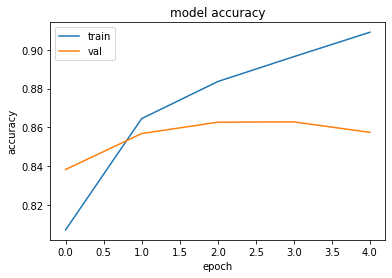

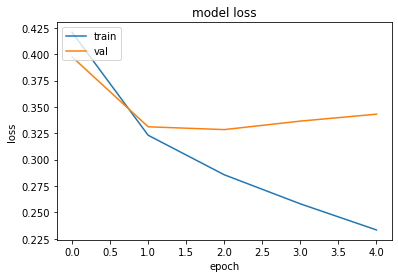

In [ ]:
plt.plot(history1_3.history['accuracy'])
plt.plot(history1_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history1_3.history['loss'])
plt.plot(history1_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

- 가장 정확도가 높았던 model1_3(RMSprop optimizer)을 활용하여 예측합니다.

In [ ]:
def review_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = tokenizer_m.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = 83) # 패딩
  score = float(loaded_model1_3.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
review_predict('영화 보는게 힘들다')

80.36% 확률로 부정 리뷰입니다.



In [ ]:
review_predict('와 돈아깝다')

98.89% 확률로 부정 리뷰입니다.



In [ ]:
review_predict('감독 튀어와라')

92.21% 확률로 부정 리뷰입니다.



In [ ]:
review_predict('여주 겁나 이쁨')

85.94% 확률로 긍정 리뷰입니다.



In [ ]:
review_predict('이 영화 미쳤다')

74.74% 확률로 부정 리뷰입니다.



In [ ]:
review_predict('이 영화 미쳤다 꼭 봐라')

89.31% 확률로 긍정 리뷰입니다.



- 생각보다 잘 맞추는 것 같습니다.  
'미쳤다'는 의미가 어조에 따라 다를 수 있어서 예측을 잘 못하는 것 같습니다.

In [ ]:
model1_3.save('/gdrive/My Drive/Colab Notebooks/model/best_model1_3.h5')

### 1.3 Re_Start

#### 1.3.1 Data Preprocessing

- 위에서 만든 movie review model의 단어장에는 pad만 들어가 있습니다.  
물론 잘 돌아가는걸 확인했지만 이번에는 사전에 'BOS', 'UNK', 'UNUSED' 토큰을 만들어 다시 구성해봅니다.  
- 데이터를 다시 불러와서 기본적인 전처리를 수행합니다.

In [51]:
train_data = pd.read_table('/gdrive/My Drive/Colab Notebooks/data/movie/ratings_train.txt')
test_data = pd.read_table('/gdrive/My Drive/Colab Notebooks/data/movie/ratings_test.txt')

In [52]:
train_data.drop_duplicates(subset=['document'], keep='first', inplace=True)
test_data.drop_duplicates(subset=['document'], keep='first', inplace=True)

In [53]:
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

In [54]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)

test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [55]:
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

In [56]:
print(len(train_data),len(test_data))

145393 48852


- 전처리 후 train, test 갯수가 위에서 수행한 것과 동일합니다.  
다음으로 넘어갑니다.

- tokenizer는 Mecab을 사용합니다.

#### 1.3.2 Tokenize

In [57]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

- 위에서 단어장을 만들 때 vocab size는 49946 + 1(pad), 총 49,947개 였습니다. 이번에는 40,000로 지정해 만들어봅니다. 

- 위에서 만든 load_data 함수를 이용합니다.  
간단한 전처리를 마친 train, test 데이터를 토큰화하고, word index를 만듭니다.

In [58]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, 40000)

In [59]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

145393 48852
145393 48852


- index_to_word를 만들어줍니다.

In [60]:
index_to_word = {index:word for word, index in word_to_index.items()}

- 이번에도 maxlen은 가장 긴 문장의 길이 값을 줍니다.

리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 13.801348190947861


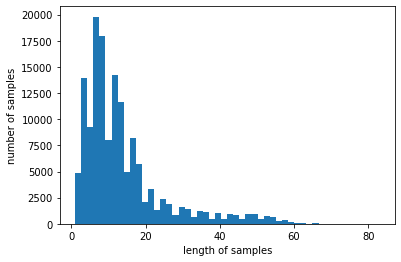

In [64]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- keras의 pad_sequences를 이용해 padding을 진행합니다.

In [66]:
max_len = 83

In [67]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=max_len)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=max_len)

- validation data를 나눠줍니다.

In [68]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size = 0.2, shuffle=False)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(116304, 83) (116304,)
(29076, 83) (29076,)


#### 1.3.3 Model2_1

- 위에서 사용한 LSTM모델을 다시 가져옵니다.
- Nadam Optimizer를 사용합니다.

In [80]:
vocab_size = 40000
word_vector_dim = 128

# model
model2_1 = keras.Sequential()
model2_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2_1.add(keras.layers.LSTM(512))
model2_1.add(keras.layers.Dropout(0.3))
model2_1.add(keras.layers.Dense(32, activation='relu'))
model2_1.add(keras.layers.Dropout(0.3))
model2_1.add(keras.layers.Dense(16, activation='relu'))
model2_1.add(keras.layers.Dense(1, activation='sigmoid')) 

model2_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         5120000   
                                                                 
 lstm_2 (LSTM)               (None, 512)               1312768   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                16416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                

In [81]:
model2_2 = model2_1
model2_3 = model2_1

In [72]:
model2_1.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience = 2, mode = 'min')
mc = ModelCheckpoint("best_model2_1.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
              
epochs=30
batch_size=256

history2_1 = model2_1.fit(x_train,
                          y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(x_val, y_val),
                          callbacks = [es, mc])

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 0.4368 - accuracy: 0.8000
Epoch 1: val_accuracy improved from -inf to 0.83622, saving model to best_model2_1.h5
455/455 [==============================] - 27s 44ms/step - loss: 0.4368 - accuracy: 0.8000 - val_loss: 0.3617 - val_accuracy: 0.8362
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.8696
Epoch 2: val_accuracy improved from 0.83622 to 0.84895, saving model to best_model2_1.h5
455/455 [==============================] - 20s 43ms/step - loss: 0.3123 - accuracy: 0.8696 - val_loss: 0.3460 - val_accuracy: 0.8489
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.8948
Epoch 3: val_accuracy improved from 0.84895 to 0.84919, saving model to best_model2_1.h5
455/455 [==============================] - 20s 43ms/step - loss: 0.2607 - accuracy: 0.8948 - val_loss: 0.3465 - val_accuracy: 0.8492
Epoch 4/30
455/455 [=============================

In [74]:
loaded_model2_1 = load_model('best_model2_1.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model2_1.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 9s 6ms/step - loss: 0.3758 - accuracy: 0.8469

 테스트 정확도: 0.8469


#### 1.3.4 Model2_2

- 같은 LSTM 모델로 Adam Optimizer를 사용합니다.

In [78]:
model2_2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience = 2, mode = 'min')
mc = ModelCheckpoint("best_model2_2.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
              
epochs=30
batch_size=256

history2_2 = model2_2.fit(x_train,
                          y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(x_val, y_val),
                          callbacks = [es, mc])

Epoch 1/30
454/455 [============================>.] - ETA: 0s - loss: 0.4116 - accuracy: 0.8118
Epoch 1: val_accuracy improved from -inf to 0.84300, saving model to best_model2_2.h5
455/455 [==============================] - 22s 44ms/step - loss: 0.4116 - accuracy: 0.8118 - val_loss: 0.3519 - val_accuracy: 0.8430
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.8775
Epoch 2: val_accuracy improved from 0.84300 to 0.85008, saving model to best_model2_2.h5
455/455 [==============================] - 19s 43ms/step - loss: 0.2957 - accuracy: 0.8775 - val_loss: 0.3364 - val_accuracy: 0.8501
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9050
Epoch 3: val_accuracy improved from 0.85008 to 0.85101, saving model to best_model2_2.h5
455/455 [==============================] - 20s 43ms/step - loss: 0.2348 - accuracy: 0.9050 - val_loss: 0.3600 - val_accuracy: 0.8510
Epoch 4/30
454/455 [============================>

In [79]:
loaded_model2_2 = load_model('best_model2_2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model2_2.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 9s 6ms/step - loss: 0.3663 - accuracy: 0.8481

 테스트 정확도: 0.8481


#### 1.3.5 Model2_3

- RMSprop Optimizer를 사용합니다.

In [82]:
model2_3.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience = 2, mode = 'min')
mc = ModelCheckpoint("best_model2_3.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
              
epochs=30
batch_size=256

history2_3 = model2_3.fit(x_train,
                          y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(x_val, y_val),
                          callbacks = [es, mc])

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 0.4383 - accuracy: 0.8027
Epoch 1: val_accuracy improved from -inf to 0.84142, saving model to best_model2_3.h5
455/455 [==============================] - 21s 43ms/step - loss: 0.4383 - accuracy: 0.8027 - val_loss: 0.3717 - val_accuracy: 0.8414
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 0.3278 - accuracy: 0.8616
Epoch 2: val_accuracy improved from 0.84142 to 0.85486, saving model to best_model2_3.h5
455/455 [==============================] - 19s 42ms/step - loss: 0.3278 - accuracy: 0.8616 - val_loss: 0.3365 - val_accuracy: 0.8549
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 0.2900 - accuracy: 0.8795
Epoch 3: val_accuracy improved from 0.85486 to 0.86068, saving model to best_model2_3.h5
455/455 [==============================] - 19s 42ms/step - loss: 0.2900 - accuracy: 0.8795 - val_loss: 0.3326 - val_accuracy: 0.8607
Epoch 4/30
455/455 [=============================

In [83]:
loaded_model2_3 = load_model('best_model2_3.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model2_3.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 9s 6ms/step - loss: 0.3466 - accuracy: 0.8568

 테스트 정확도: 0.8568


In [85]:
model2_3.save('/gdrive/My Drive/Colab Notebooks/model/best_model2_3.h5')

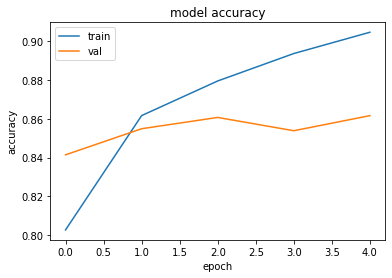

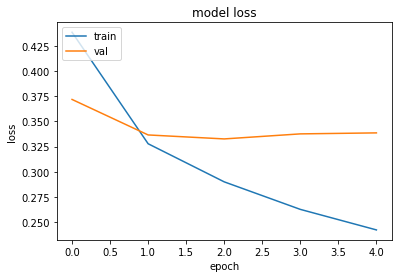

In [88]:
plt.plot(history2_3.history['accuracy'])
plt.plot(history2_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history2_3.history['loss'])
plt.plot(history2_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

- epoch 5에서 val_accuracy가 최대이고, epoch 3에서 val_loss가 최소인 것을 확인할 수 있습니다.

#### 1.3.6 Model3_1

- model3_1은 CNN을 이용해봅니다.  

In [84]:
model3_1 = keras.Sequential()
model3_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3_1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model3_1.add(keras.layers.MaxPooling1D(5))
model3_1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model3_1.add(keras.layers.GlobalMaxPooling1D())
model3_1.add(keras.layers.Dense(32, activation='relu'))
model3_1.add(keras.layers.Dropout(0.3))
model3_1.add(keras.layers.Dense(16, activation='relu'))
model3_1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         5120000   
                                                                 
 conv1d (Conv1D)             (None, None, 16)          14352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_9 (Dense)             (None, 32)               

In [86]:
model3_1.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience = 2, mode = 'min')
mc = ModelCheckpoint("best_model3_1.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
              
epochs=30
batch_size=256

history3_1 = model3_1.fit(x_train,
                          y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(x_val, y_val),
                          callbacks = [es, mc])

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.7437
Epoch 1: val_accuracy improved from -inf to 0.79767, saving model to best_model3_1.h5
455/455 [==============================] - 11s 7ms/step - loss: 0.4980 - accuracy: 0.7437 - val_loss: 0.4243 - val_accuracy: 0.7977
Epoch 2/30
449/455 [============================>.] - ETA: 0s - loss: 0.3820 - accuracy: 0.8250
Epoch 2: val_accuracy improved from 0.79767 to 0.81039, saving model to best_model3_1.h5
455/455 [==============================] - 3s 6ms/step - loss: 0.3818 - accuracy: 0.8250 - val_loss: 0.4067 - val_accuracy: 0.8104
Epoch 3/30
454/455 [============================>.] - ETA: 0s - loss: 0.3189 - accuracy: 0.8588
Epoch 3: val_accuracy did not improve from 0.81039
455/455 [==============================] - 3s 6ms/step - loss: 0.3189 - accuracy: 0.8588 - val_loss: 0.4199 - val_accuracy: 0.8076
Epoch 4/30
454/455 [============================>.] - ETA: 0s - loss: 0.2558 - accuracy: 0.8

In [87]:
loaded_model3_1 = load_model('best_model3_1.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model3_1.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 4s 2ms/step - loss: 0.4121 - accuracy: 0.8048

 테스트 정확도: 0.8048


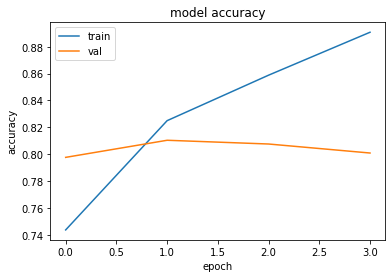

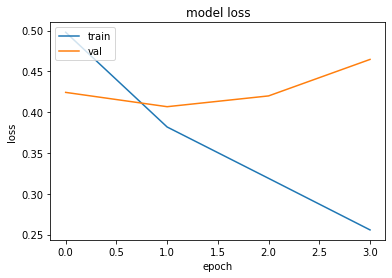

In [89]:
plt.plot(history3_1.history['accuracy'])
plt.plot(history3_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history3_1.history['loss'])
plt.plot(history3_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

- 생각보다 결과가 좋지 못합니다. 위 model2_3을 사용합니다.

#### 1.3.7 Embedding Layer

- 학습된 model2_3의 embedding layer를 통해 단어를 집어넣고 연관성 있는 단어들을 뽑아내봅니다.

In [91]:
word2vec_file_path = '/gdrive/My Drive/Colab Notebooks/data/movie/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2_3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.040106  ,  0.02104081, -0.02666196, -0.03671184, -0.06888315,
       -0.02614158, -0.01506929, -0.01629592,  0.04930503, -0.0016377 ,
        0.0572873 , -0.08239391,  0.00698249, -0.04645717, -0.15335852,
        0.11126245, -0.10779494, -0.04618469,  0.03494925, -0.02541876,
        0.04149155, -0.00429845, -0.05621784,  0.05676606,  0.00099679,
       -0.07071314,  0.07661533, -0.08946599,  0.10125253, -0.06440735,
       -0.00720464,  0.07661492, -0.02200258, -0.05603587, -0.07048534,
       -0.00499029,  0.01775517, -0.06473803, -0.0310658 ,  0.04424819,
       -0.03293661,  0.08573128,  0.07584577, -0.04507392, -0.08952572,
        0.14408758, -0.04233633, -0.0737031 , -0.01749332, -0.06875283,
       -0.06893416, -0.02330461,  0.05829863,  0.01670317,  0.10313595,
       -0.03671516, -0.09523117, -0.0407689 , -0.0068488 ,  0.0394184 ,
       -0.05653837,  0.02522416, -0.0835469 ,  0.01041655, -0.00911232,
       -0.07090495, -0.07175186,  0.00792894, -0.02698866,  0.13

In [92]:
word_vectors.similar_by_word("여주")

[('성우', 0.8116530179977417),
 ('이라도', 0.8100594878196716),
 ('극치', 0.7933149337768555),
 ('반복', 0.7894351482391357),
 ('공포물', 0.7880476713180542),
 ('세여', 0.7879423499107361),
 ('괴리', 0.7862759828567505),
 ('작렬', 0.7846822738647461),
 ('돌려', 0.7832977771759033),
 ('팀', 0.7819128036499023)]

In [93]:
word_vectors.similar_by_word("감독")

[('양심', 0.8928641080856323),
 ('진행', 0.8858894109725952),
 ('액션물', 0.8825536966323853),
 ('감흥', 0.8755953311920166),
 ('깡패', 0.872478187084198),
 ('괴담', 0.8720375895500183),
 ('플롯', 0.8717002272605896),
 ('도대체', 0.869542121887207),
 ('제작진', 0.8674465417861938),
 ('자는', 0.8672112226486206)]

- 특히 감독에 대해서는 리뷰어들의 분노가 잘 드러나는 것 같습니다.

### 1.4 Word2Vec

#### 1.4.1 Word2Vec Load

- 이번에는 word2vec를 다운받아 사용해봅니다.

In [94]:
word2vec_path = '/gdrive/My Drive/Colab Notebooks/data/movie/ko.bin'
word2vec_1 = Word2Vec.load(word2vec_path)

vector_1 = word2vec_1['영화']
vector_1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

In [95]:
word2vec_1.similar_by_word("여주")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('계룡', 0.7370280623435974),
 ('삼천포', 0.729030191898346),
 ('오산시', 0.7145974040031433),
 ('양주', 0.7049307823181152),
 ('양평군', 0.6866284608840942),
 ('의정부시', 0.6863290071487427),
 ('평택시', 0.6805356740951538),
 ('광주시', 0.6796330809593201),
 ('동두천시', 0.6781470775604248),
 ('강계', 0.6770763993263245)]

In [97]:
word2vec_1.similar_by_word("감독")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감독인', 0.7203366756439209),
 ('총감독', 0.6801566481590271),
 ('감독직', 0.5861766338348389),
 ('김성근', 0.5718862414360046),
 ('코치', 0.5694025158882141),
 ('구단주', 0.5456192493438721),
 ('영화감독', 0.5423160791397095),
 ('히치콕', 0.5321968197822571),
 ('수석', 0.5142989754676819),
 ('주연', 0.5122917890548706)]

- 야구 감독도 감독입니다...

#### 1.4.2 Model4_1

- 불러온 word2vec를 embedding layer에 넣어서 다시 모델을 만들어줍니다.  
비교를 위해 vocab_size는 동일하게 40000, ~word_vector_dim은 128을 줍니다.~  
could not broadcast input array from shape (200,) into shape (128,) 에러가 발생합니다.  
200으로 설정합니다...



In [104]:
vocab_size = 40000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200

In [105]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec_1:
        embedding_matrix[i] = word2vec_1[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [106]:
embedding_matrix.shape

(40000, 200)

In [107]:
# model
model4_1 = keras.Sequential()
model4_1.add(keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=max_len,
                                    trainable=True
                                    ))
model4_1.add(keras.layers.LSTM(512))
model4_1.add(keras.layers.Dropout(0.3))
model4_1.add(keras.layers.Dense(32, activation='relu'))
model4_1.add(keras.layers.Dropout(0.3))
model4_1.add(keras.layers.Dense(16, activation='relu'))
model4_1.add(keras.layers.Dense(1, activation='sigmoid')) 

model4_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 83, 200)           8000000   
                                                                 
 lstm_3 (LSTM)               (None, 512)               1460224   
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                16416     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                

- model2_3 Total params: 6,449,729  
model2_3과 비교해보면 너무나 당연하게 embedding 단계에서 파라미터 갯수가 늘었습니다.

In [108]:
model4_1.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience = 2, mode = 'min')
mc = ModelCheckpoint("best_model4_1.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
              
epochs=30
batch_size=256

history4_1 = model4_1.fit(x_train,
                          y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(x_val, y_val),
                          callbacks = [es, mc])

Epoch 1/30
454/455 [============================>.] - ETA: 0s - loss: 0.4709 - accuracy: 0.7719
Epoch 1: val_accuracy improved from -inf to 0.81610, saving model to best_model4_1.h5
455/455 [==============================] - 30s 61ms/step - loss: 0.4707 - accuracy: 0.7720 - val_loss: 0.4484 - val_accuracy: 0.8161
Epoch 2/30
454/455 [============================>.] - ETA: 0s - loss: 0.3392 - accuracy: 0.8529
Epoch 2: val_accuracy improved from 0.81610 to 0.83584, saving model to best_model4_1.h5
455/455 [==============================] - 28s 62ms/step - loss: 0.3392 - accuracy: 0.8528 - val_loss: 0.3653 - val_accuracy: 0.8358
Epoch 3/30
454/455 [============================>.] - ETA: 0s - loss: 0.2891 - accuracy: 0.8779
Epoch 3: val_accuracy improved from 0.83584 to 0.85287, saving model to best_model4_1.h5
455/455 [==============================] - 28s 62ms/step - loss: 0.2892 - accuracy: 0.8779 - val_loss: 0.3273 - val_accuracy: 0.8529
Epoch 4/30
455/455 [=============================

In [109]:
loaded_model4_1 = load_model('best_model4_1.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model4_1.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 10s 6ms/step - loss: 0.3224 - accuracy: 0.8647

 테스트 정확도: 0.8647


In [110]:
model4_1.save('/gdrive/My Drive/Colab Notebooks/model/best_model4_1.h5')

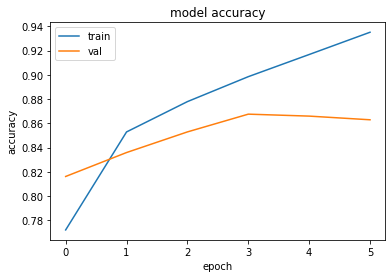

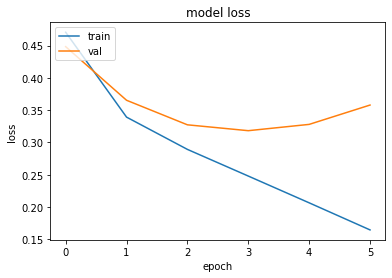

In [111]:
plt.plot(history4_1.history['accuracy'])
plt.plot(history4_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history4_1.history['loss'])
plt.plot(history4_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

- epoch 4에서 최대 val_accuracy와 최소 val_loss를 보여줍니다.

## 2. Bert


- 이번에는 그 유명한 Bert의 pretrained tokenizer와 model을 사용해봅니다.  
- 아래의 사이트를 바탕으로 코드를 구동했습니다.  
- https://wikidocs.net/book/2155  
- https://velog.io/@jaehyeong/Fine-tuning-Bert-using-Transformers-and-TensorFlow

### 2.1 Module

In [1]:
!pip install -q tensorflow-gpu==2.7.0

     |████████████████████████████████| 489.6 MB 22 kB/s 
     |████████████████████████████████| 1.3 MB 53.8 MB/s 
     |████████████████████████████████| 463 kB 75.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires keras<2.9,>=2.8.0rc0, but you have keras 2.7.0 which is incompatible.
tensorflow 2.8.2+zzzcolab20220527125636 requires tensorflow-estimator<2.9,>=2.8, but you have tensorflow-estimator 2.7.0 which is incompatible.


In [2]:
!pip install transformers==4.12.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 7.9 MB/s 
     |████████████████████████████████| 880 kB 74.6 MB/s 
     |████████████████████████████████| 596 kB 76.8 MB/s 
     |████████████████████████████████| 3.3 MB 83.9 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=4d840190808aa25b44ff6b753a978010c95f9c346184997fa0b100ee8fd56ebf
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [36]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import urllib.request

import transformers
from transformers import BertTokenizer
from transformers import BertTokenizerFast
from transformers import get_linear_schedule_with_warmup
from transformers import TFBertForSequenceClassification
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

from google.colab import drive
from google.colab.patches import cv2_imshow

In [4]:
%matplotlib inline

In [5]:
tf.__version__

'2.7.0'

In [6]:
transformers.__version__

'4.12.5'

- fine-tuning을 진행하므로 간단할 줄 알았지만 생각보다 version 문제가 큽니다.

### 2.2 Data

#### 2.2.1 Data Load

- 데이터를 불러옵니다.

In [7]:
drive.mount('/gdrive')

Mounted at /gdrive


In [8]:
train_data = pd.read_table('/gdrive/My Drive/Colab Notebooks/data/movie/ratings_train.txt')
test_data = pd.read_table('/gdrive/My Drive/Colab Notebooks/data/movie/ratings_test.txt')

#### 2.2.2 Data Preprocessing

- 앞단과 같으므로 빠르게 처리합니다.

In [9]:
train_data.drop_duplicates(subset=['document'], keep='first', inplace=True)
test_data.drop_duplicates(subset=['document'], keep='first', inplace=True)

In [10]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [11]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [12]:
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


id            0
document    789
label         0
dtype: int64


In [13]:
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


id            0
document    789
label         0
dtype: int64


In [14]:
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

In [15]:
print(len(train_data),len(test_data))

145393 48852


#### 2.2.3 Tokenize

- pretrained tokenizer를 불러옵니다.  

In [16]:
tokenizer5_1 = BertTokenizerFast.from_pretrained('klue/bert-base')

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

- tolist로 list 형태로 만들어줍니다.

In [17]:
X_train_list = train_data['document'].tolist()
X_test_list = test_data['document'].tolist()
y_train = train_data['label'].tolist()
y_test = test_data['label'].tolist()

- 위에서 불러온 tokenizer로 토큰화를 진행합니다.

In [18]:
X_train = tokenizer5_1(X_train_list, truncation=True, padding=True)
X_test = tokenizer5_1(X_test_list, truncation=True, padding=True)

### 2.3 Model

- 먼저 dataset을 구성합니다. validation을 test data로 넣었습니다.

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

- 최애 Nadam optimizer를 사용합니다.

In [20]:
optimizer5_1 = tf.keras.optimizers.Nadam(learning_rate=5e-5)

- 마찬가지로 pretrained model을 불러와 컴파일합니다.

In [21]:
model5_1 = TFBertForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2, from_pt=True)
model5_1.compile(optimizer=optimizer5_1, loss=model5_1.compute_loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- compute_loss는 training loss를 반환해 model의 metrics를 업데이트 하기 위해 사용한다고 합니다.

In [22]:
model5_1.compute_loss

<bound method TFSequenceClassificationLoss.compute_loss of <transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification object at 0x7f4c8da35410>>

- 바로 훈련을 시켜줍니다.  
- ModelCheckpoint를 추가하고 싶었으나 오류가 발생해 빼고 진행합니다.

In [23]:
es = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0.001,
    patience=2)

model5_1.fit(
    train_dataset.shuffle(10000).batch(32), epochs=5, batch_size=64,
    validation_data = val_dataset.shuffle(10000).batch(64),
    callbacks = [es]
)

Epoch 1/5
4544/4544 [==============================] - 2452s 533ms/step - loss: 0.2970 - accuracy: 0.8731 - val_loss: 0.2602 - val_accuracy: 0.8909
Epoch 2/5
4544/4544 [==============================] - 2421s 533ms/step - loss: 0.2127 - accuracy: 0.9139 - val_loss: 0.2791 - val_accuracy: 0.8877
Epoch 3/5
4544/4544 [==============================] - 2423s 533ms/step - loss: 0.1508 - accuracy: 0.9414 - val_loss: 0.2969 - val_accuracy: 0.8902


- validation_dataset은 test_data입니다.  
평가해봅니다.

In [24]:
model5_1.evaluate(val_dataset.batch(1024))

48/48 [==============================] - 186s 4s/step - loss: 0.2969 - accuracy: 0.8902


[0.29691803455352783, 0.8901580572128296]

- 매우 준수합니다

In [34]:
model5_1.save_pretrained('/gdrive/My Drive/Colab Notebooks/model/bert-base')
tokenizer5_1.save_pretrained('/gdrive/My Drive/Colab Notebooks/model/bert-base')

('/gdrive/My Drive/Colab Notebooks/model/bert-base/tokenizer_config.json',
 '/gdrive/My Drive/Colab Notebooks/model/bert-base/special_tokens_map.json',
 '/gdrive/My Drive/Colab Notebooks/model/bert-base/vocab.txt',
 '/gdrive/My Drive/Colab Notebooks/model/bert-base/added_tokens.json',
 '/gdrive/My Drive/Colab Notebooks/model/bert-base/tokenizer.json')

- 생각해보니... model을 저장합니다.  
런타임을 삭제하면 다시 tensorflow가 원래 버전으로 돌아오니 pretrained_model, tokenize만 불러와서 pipeline에 넣어주면 될 것 같습니다.

In [42]:
loaded_tokenizer = BertTokenizerFast.from_pretrained('/gdrive/My Drive/Colab Notebooks/model/bert-base')
loaded_model = TFBertForSequenceClassification.from_pretrained('/gdrive/My Drive/Colab Notebooks/model/bert-base')

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at /gdrive/My Drive/Colab Notebooks/model/bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /gdrive/My Drive/Colab Notebooks/model/bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


- 한글로 긍정, 부정, %까지 출력하게끔 간단한 함수를 만들어줍니다.

In [81]:
def text_classifier2(sentence):
  score = text_classifier(sentence)[0][0]['score']
  if(score > 0.5):
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format((1 - score) * 100))

In [91]:
text_classifier2('졸려서 자다감')

99.91% 확률로 부정 리뷰입니다.



In [84]:
text_classifier2('와 돈아깝다')

99.92% 확률로 부정 리뷰입니다.



In [93]:
text_classifier2('감독 튀어와라')

87.46% 확률로 부정 리뷰입니다.



In [86]:
text_classifier2('여주 겁나 이쁨')

97.23% 확률로 긍정 리뷰입니다.



In [101]:
text_classifier2('다들 꼭 봤으면 좋겠음 나만 당할 수 없지')

94.30% 확률로 긍정 리뷰입니다.



In [87]:
text_classifier2('이 영화 미쳤다')

87.95% 확률로 부정 리뷰입니다.



In [88]:
text_classifier2('이 영화 미쳤다 꼭 봐라')

93.57% 확률로 긍정 리뷰입니다.



In [90]:
text_classifier2('조연이 찢었다')

86.77% 확률로 부정 리뷰입니다.



- 결과는 준수한 편인 것 같습니다만, 돌려말하거나 신조어에 약합니다.

## 3. ERROR

1) fail to find the dnn implementation
 - https://stackoverflow.com/questions/54473254/cudnnlstm-unknownerror-fail-to-find-the-dnn-implementation

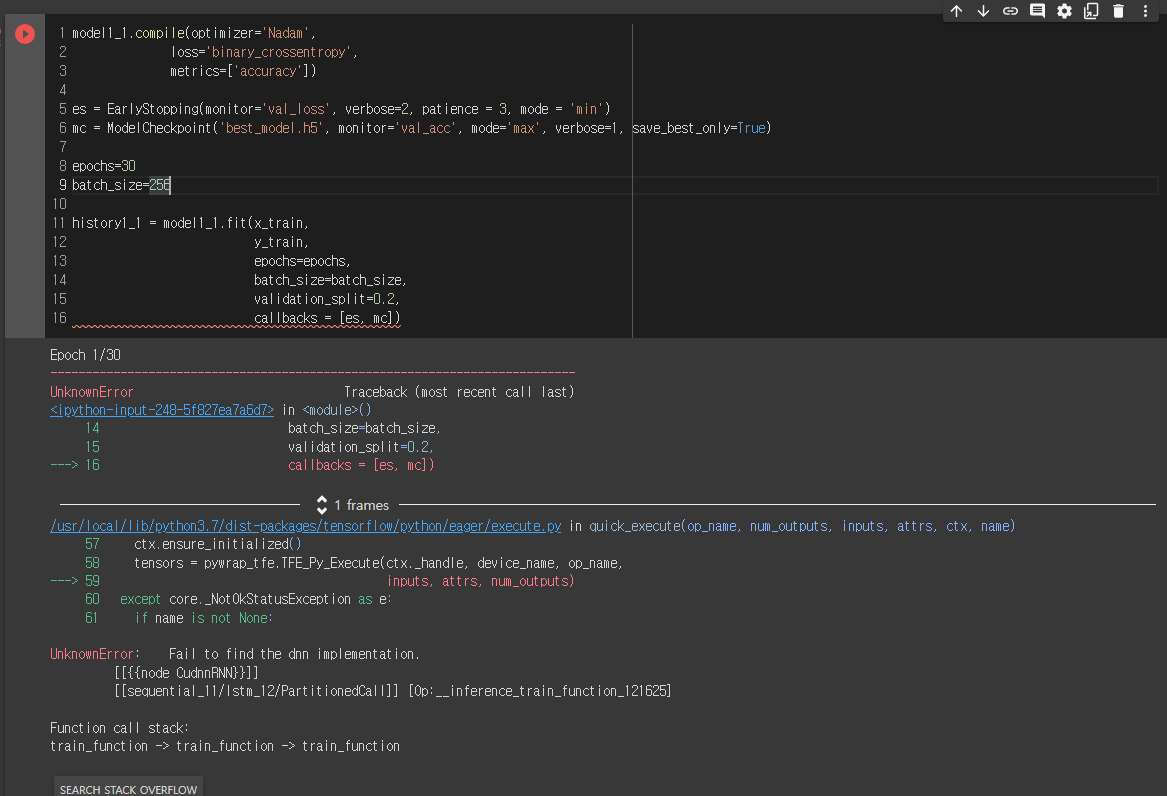

In [37]:
insert_img_1 = '/gdrive/My Drive/Colab Notebooks/model/error3.png'
insert_img_1 = cv2.imread(insert_img_1)
cv2_imshow(insert_img_1)

- CuDNN version 문제라고 하던데 tensorflow 업데이트 후 해결했습니다.  
(Bert 사용을 위해 version을 내려서 사용하다가 발생)

2) 'Nonetype' object has no attribute 'dtype' model
 - https://stackoverflow.com/questions/48600538/attributeerror-nonetype-object-has-no-attribute-dtype

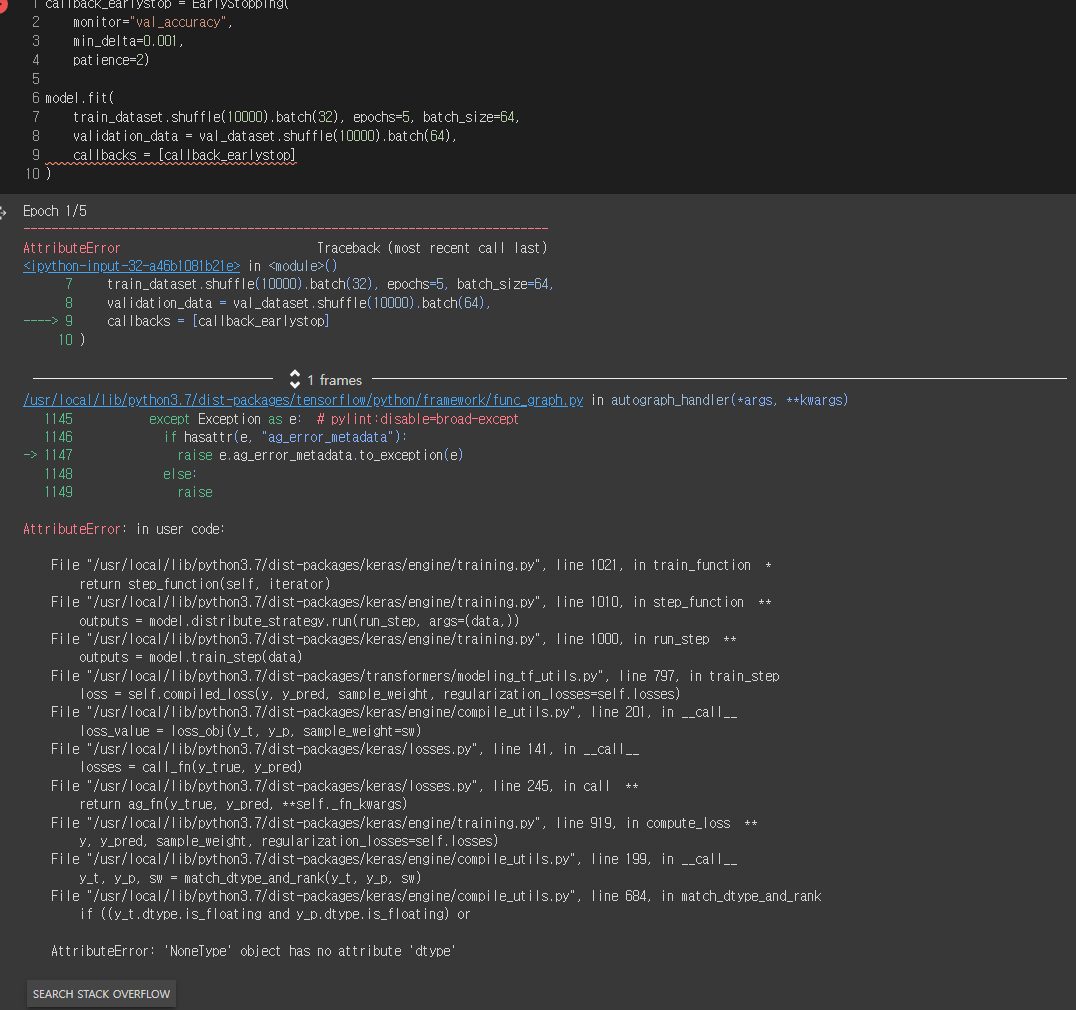

In [38]:
insert_img_2 = '/gdrive/My Drive/Colab Notebooks/model/error2.png'
insert_img_2 = cv2.imread(insert_img_2)
cv2_imshow(insert_img_2)

- data 전처리, numpy version 문제 등 다양한 해석이 있지만, tensorflow 2.7.0을 사용하는 것으로 해결했습니다.  
(tensorflow == 2.7.0 / transformors == 4.12.5)

3) Failed to import transformers.pipelines because of the following error

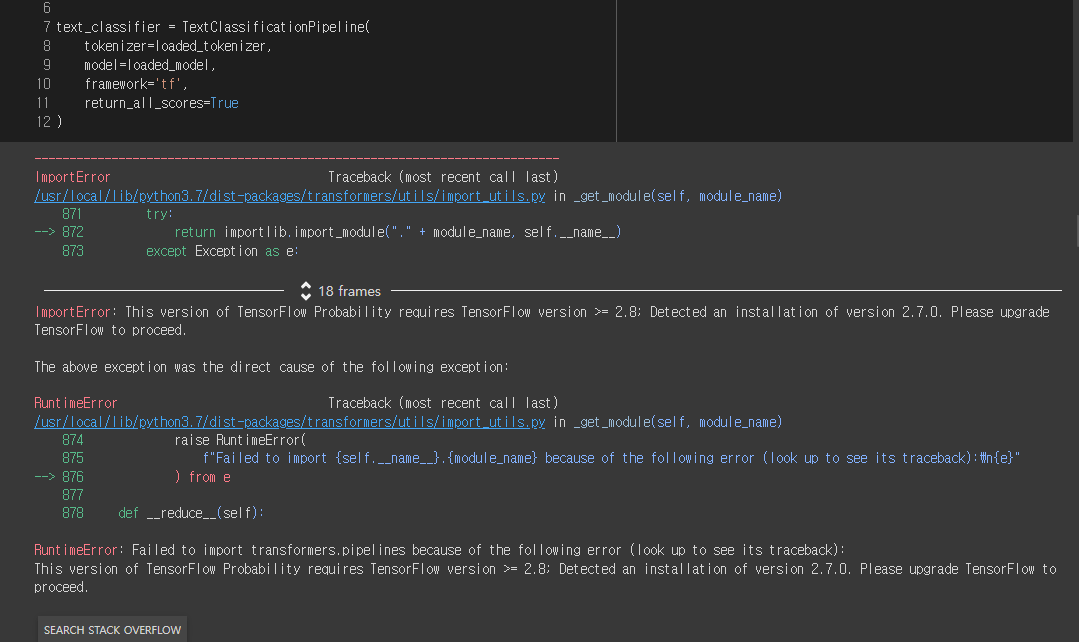

In [39]:
insert_img_3 = '/gdrive/My Drive/Colab Notebooks/model/error1.png'
insert_img_3 = cv2.imread(insert_img_3)
cv2_imshow(insert_img_3)

- error 마지막 줄에 잘 나와있습니다.  
tensorflow를 2.8 이상으로 올려줘야 transformers.pipeline을 사용할 수 있습니다.

## 4. Retrospect

##### 1) BERT로 pretrained된 model과 tokenizer 사용  
- 드디어 BERT를 사용해봅니다.  
- fine-tuning으로 pretrained model을 돌려 봤다는 부분에서 만족합니다.  
다만, 버전 에러가 너무 심하고 에러를 googling을 해도 별다른 정보가 없어 힘들었습니다.  
(특히, pretrained model을 불러와서 fit을 하려면 tensorflow 2.7.x 를 사용해야하는 점과 pipeline을 사용하려면 2.8.x를 사용해야 하는 부분)

##### 2) KcELECTRA-base
- pretrained model중 nsmc에서 정확도가 91.71로 가장 높은 KcELECTRA-base를 써보고 싶습니다.   
Kc_BERT-Large보다 Size는 약 1/3수준인데 성능이 조금 더 우수합니다.

##### 3) Model은 복잡할 필요가 없다.
 - 물론 때에 따라서 다르겠지만, model layer가 깊고 다양한 layer를 섞었다고 결과엔 큰 차이가 없었습니다.  
 단순하게 빨리 만들어서 돌려보고 하나하나 추가하는 것이 좋겠습니다.

##### 4) version 맞추기
 - 1번에도 언급했지만 gensim과 mecab, tensorflow와 transformers의 버전을 맞춰주는게 고역입니다.  
 torch도 써보고 싶은데 벌써부터 겁이 납니다.

##### 5) model save 활용
- model save를 버릇처럼 할 필요가 있겠다는 생각이 듭니다.  
버전이 다를 때 모델만 상위버전에서 로드하면 꼼수처럼 패키지 버전이 안맞는 경우를 넘어갈 수 있습니다.

## 5. References

- 아래의 사이트에서 많은 도움을 받았습니다.

1) BERT
- https://docs.likejazz.com/bert/  
- http://jalammar.github.io/illustrated-bert/  
- https://ebbnflow.tistory.com/162  
- https://wikidocs.net/book/2155  

2) BERT - Fine_tuning
- https://velog.io/@jaehyeong/Fine-tuning-Bert-using-Transformers-and-TensorFlow  

3) Preprocessing - Padding
- https://koreapy.tistory.com/604  

4) NSMC - Sentiment_predict with Hugging Face BERT
- https://github.com/deepseasw/bert-naver-movie-review/blob/master/bert_naver_movie.ipynb